In [1]:
import uproot4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import awkward1 as ak
from lxml import etree as ET
import os
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
# file_name = f"{Path.cwd()}/data/2021-12-07_nomat_10000evt_pi-_1x_21.5y_0z_2GeV.root"
file_name = f"{Path.cwd()}/data/2021-12-07_nomat_10000evt_e-_1x_21.5y_0z_2GeV.root"
cal_size=3
start_event=0
process_events=None


root_file = uproot4.open(file_name)
tree = root_file["events"]
#print(tree.keys())

entry_start = start_event

entry_stop = start_event + process_events if process_events else None
events = tree.arrays(['EcalEndcapNHits.cellID', 
                        'EcalEndcapNHits.energyDeposit', 
                        'EcalEndcapNHits.position.x', 
                        'EcalEndcapNHits.position.y', 
                        'EcalEndcapNHits.position.z',
                        'EcalEndcapNHits.truth.pdgID'],
                        aliases={"EcalEndcapNHits.cellID": "id"},
                        library="ak",
                        how=tuple,
                        entry_start=entry_start, 
                        entry_stop=entry_stop)


In [3]:
events
#events[0].type

(<Array [[3735911, 3285607, ... 3965287]] type='10000 * var * int64'>,
 <Array [[0.266, 0.000504, ... 0.00162]] type='10000 * var * float64'>,
 <Array [[10.3, 308, 267, ... 154, 133, -30.7]] type='10000 * var * float64'>,
 <Array [[215, 267, 308, ... 318, 277, 256]] type='10000 * var * float64'>,
 <Array [[-2.01e+03, -2.18e+03, ... -2.01e+03]] type='10000 * var * float64'>,
 <Array [[-211, 11, 11, 11, ... 22, 11, 11, 22]] type='10000 * var * int32'>)

In [4]:
import hist
from hist import Hist
# Create histograms
hist_hit_xy = Hist(hist.axis.Regular(50, -500, 500, name="X", label="Hits x [mm]", flow=False),
                   hist.axis.Regular(50, -500, 500, name="Y", label="Hits y [mm]", flow=False))

hist_hit_z = Hist(hist.axis.Regular(50, -2170, -2030, name="Z", label="Hits z [mm]", flow=False))

hist_total_dep = Hist(hist.axis.Regular(200, 0, 3, name="DE", label="Cal total cells E deposit [GeV]", flow=False))
hist_true_e = Hist(hist.axis.Regular(50, 0, 10, name="E", label="Energy [GeV]", flow=False))

In [5]:
# Events loop
train_data = []     # Resulting data for each event
inc_hits = []       # Cal incidence x,y,z for each event
event_count = 0
for event in zip(*events):
    arr_id, arr_de, arr_hit_x, arr_hit_y, arr_hit_z, arr_pid = event

    # Print what event is being processed
    event_count += 1
    if (event_count % 1000) == 0:
        print(f"Events processed: {event_count}")
    
    # Skip event if we don't have hits or generated particles
    if not len(arr_id) or not len(arr_de):
        continue

    # in a simple scenario (1 particle gun particle per event) 1-st hit is an incidence hit
    hit_x, hit_y, hit_z, pid = arr_hit_x[0], arr_hit_y[0], arr_hit_z[0], arr_pid[0]

    total_deposit = 0

    # Form a flat data training array. Indexes are like:
    # [0] [1] [2]
    # [3] [4] [5]
    # [6] [7] [8]
    # event_train_data = cal_size*cal_size*[0]

    for de in arr_de :
        total_deposit += de

        #print(cell.col, cell.row, cell.adc)
    # train_data.append(event_train_data)
    inc_hits.append((hit_x, hit_y, hit_z))

    # Fill some histograms
    hist_hit_xy.fill(hit_x, hit_y)
    hist_hit_z.fill(hit_z)
    hist_total_dep.fill(total_deposit)
    # hist_true_e.fill(arr_true_e[0])

histograms = {
    'hit_xy': hist_hit_xy,
    'hit_z': hist_hit_z,
    'total_dep': hist_total_dep,
    'true_e': hist_true_e
}

Events processed: 1000
Events processed: 2000
Events processed: 3000
Events processed: 4000
Events processed: 5000
Events processed: 6000
Events processed: 7000
Events processed: 8000
Events processed: 9000
Events processed: 10000


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x0000022B219FEEB0>, cbar=<matplotlib.colorbar.Colorbar object at 0x0000022B219C0B50>, text=[])

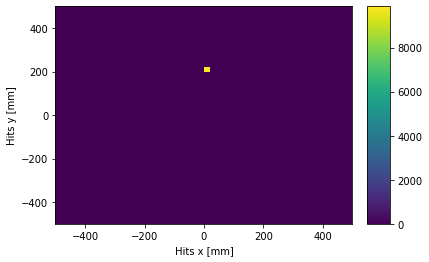

In [6]:
hist_hit_xy.plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x0000022B21DB3550>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

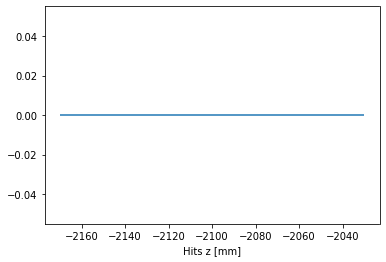

In [7]:
hist_hit_z.plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x0000022B21E446A0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

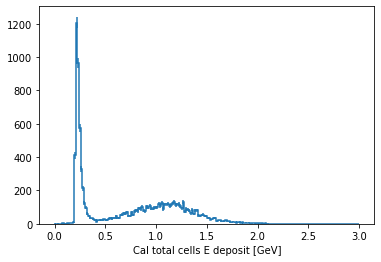

In [8]:
hist_total_dep.plot()